In [1]:
%fs ls "dbfs:/FileStore/tables/Roads/"

path,name,size
dbfs:/FileStore/tables/Roads/Bay_Area_edges/,Bay_Area_edges/,0
dbfs:/FileStore/tables/Roads/Bay_Area_nodes/,Bay_Area_nodes/,0
dbfs:/FileStore/tables/Roads/Bay_Area_vertices/,Bay_Area_vertices/,0
dbfs:/FileStore/tables/Roads/NYC/,NYC/,0
dbfs:/FileStore/tables/Roads/NYC_Roads/,NYC_Roads/,0
dbfs:/FileStore/tables/Roads/Roads_BayArea.cpg,Roads_BayArea.cpg,5
dbfs:/FileStore/tables/Roads/Roads_BayArea.dbf,Roads_BayArea.dbf,46607160
dbfs:/FileStore/tables/Roads/Roads_BayArea.prj,Roads_BayArea.prj,145
dbfs:/FileStore/tables/Roads/Roads_BayArea.sbn,Roads_BayArea.sbn,2363924
dbfs:/FileStore/tables/Roads/Roads_BayArea.sbx,Roads_BayArea.sbx,78124


In [2]:
!pip install geopandas

In [3]:
#from graphframes import *
import geopandas as gpd
from pyspark.sql.types import *
from pyspark.sql.functions import explode, monotonically_increasing_id, udf, col, count, collect_set, lit
from math import radians, cos, sin, asin, sqrt, atan2
from pyspark.sql.window import Window

In [4]:
bay_area_roads = gpd.read_file('/dbfs/FileStore/tables/Roads/Roads_BayArea.shp')

"""
######Paths unsuitable for cars (All the track roads plus the list below)  #######
bridleway - Paths for horse riding 
cycleway - Paths for cycling 
footway - Footpaths
path - Unspecified paths h
steps - Flights of steps on footpaths 
service - Service roads for access to buildings, parking lots, etc.
track - For agricultural use, in forests, etc. Often gravel roads.

###Tracks can be assigned a “tracktype” from 1 (asphalt or heavily compacted) to 5 (hardly visible).  ###
track_grade1
track_grade2
track_grade3
track_grade4
track_grade5
"""

exclude_catg = ['service', 'footway' , 'bridleway', 'cycleway',  'path', 'steps',  'track', 'track_grade1', 'track_grade2', 'track_grade3', 'track_grade4', 'track_grade5']
bay_area_roads = bay_area_roads.loc[~bay_area_roads["fclass"].isin(exclude_catg)]

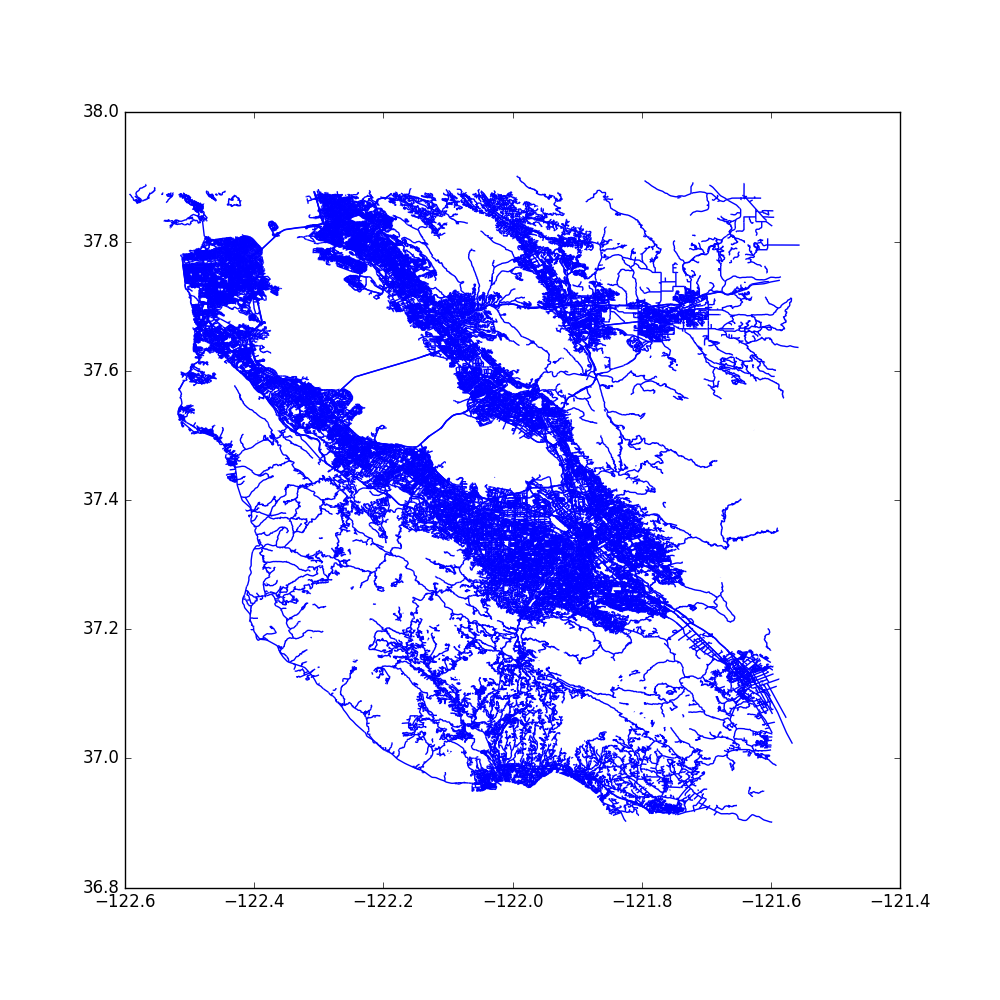

In [5]:
#Display drivable roads which will participate in the graph
import matplotlib.pyplot as plt
f, ax = plt.subplots(1, figsize=(10,10))
f = bay_area_roads.plot(ax = ax)
display(f.figure)

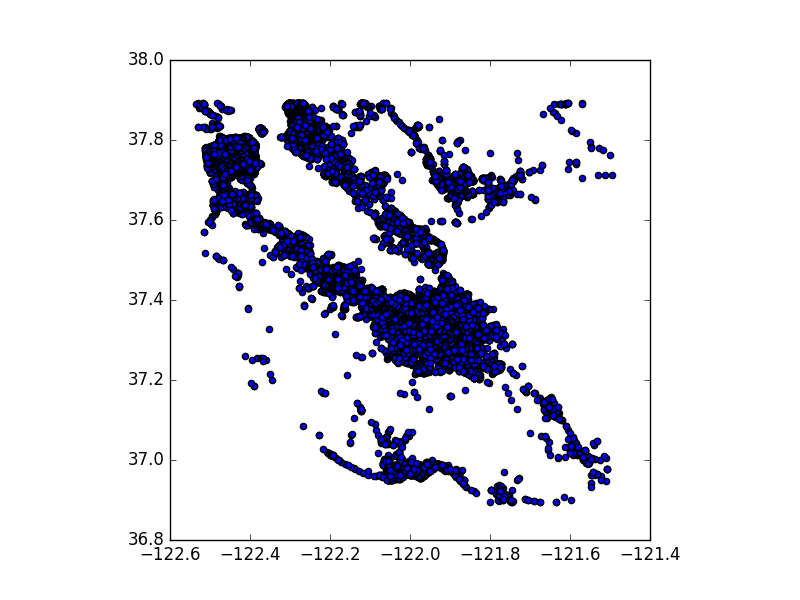

In [6]:
traffic_impediments = gpd.read_file("/dbfs/FileStore/tables/Roads/Traffic_BayArea.shp")
"""
*******
Following fclass categories can be considered impeding traffic. We can use this to add a delay when route passes through one of these impediments
*******
traffic_signals - Traffic lights. 
stop - A stop sign. 
crossing - A place where the street is crossed by pedestrians or a railway.
"""

impediments_fclass = ['crossing' , 'stop' , 'traffic_signals']
traffic_impediments = traffic_impediments.loc[traffic_impediments["fclass"].isin(impediments_fclass)]
g = traffic_impediments.plot()
display(g.figure)

In [7]:
traffic_impediments.tail()

Out[ 11 ]: 
 osm_id code fclass name geometry
61578 5336422556 5203 stop None POINT (-122.119081 37.6661554)
61579 5336422557 5203 stop None POINT (-122.1191591 37.6662984)
61580 5336422578 5203 stop None POINT (-122.1193966 37.6669139)
61581 5336422579 5203 stop None POINT (-122.1191601 37.6670904)
61583 5339088999 5204 crossing None POINT (-122.4626102 37.7140308)

In [8]:
bay_area_roads["list_road_segments"] = \
bay_area_roads["geometry"].apply(lambda geom : list(zip(*geom.xy)))

In [9]:
bay_area_roads.tail()

Out[ 14 ]: 
 osm_id code fclass name ref oneway maxspeed \
254588 552616042 5115 tertiary Alder Drive None B 64 
254589 552616043 5115 tertiary Alder Drive None F 64 
254590 552616118 5122 residential Buchanan Street None B 0 
254591 552616119 5122 residential Beach Street None F 0 
254592 552619476 5122 residential None None B 0 

 layer bridge tunnel \
254588 0.0 F F 
254589 0.0 F F 
254590 0.0 F F 
254591 0.0 F F 
254592 0.0 F F 

 geometry \
254588 LINESTRING (-121.9137148 37.4136598, -121.9142... 
254589 LINESTRING (-121.9132784 37.4139034, -121.9136... 
254590 LINESTRING (-122.4337264 37.8049476, -122.4337... 
254591 LINESTRING (-122.4339267 37.8050969, -122.4339... 
254592 LINESTRING (-121.9060059 37.4193972, -121.9064... 

 list_road_segments 
254588 [(-121.9137148, 37.4136598), (-121.9142689, 37... 
254589 [(-121.9132784, 37.4139034), (-121.913643, 37.... 
254590 [(-122.4337264, 37.8049476), (-122.4337435, 37... 
254591 [(-122.4339267, 37.8050969), (-122.4339943, 37... 
254592 [(-121.9060059, 37.4193972), (-121.9064468, 37...

In [10]:
traffic_impediments["name"] = traffic_impediments["geometry"].apply(lambda geom : geom.coords[0])

In [11]:
#Remove geometry column so that it can be converted into a Spark Dataframe
new_df = bay_area_roads[['osm_id', 'fclass', 'name', 'ref', 'oneway', 'maxspeed', 'list_road_segments']]
imped_df = traffic_impediments[['osm_id', 'fclass', 'name']]

In [12]:
schema = StructType([
  StructField("osm_id", StringType(), True),
  StructField("fclass", StringType(), True),
  StructField("name", StringType(), True),
  StructField("ref", StringType(), True), 
  StructField("oneway", StringType(), True), 
  StructField("maxspeed", LongType(), True), 
  StructField("coordinates", ArrayType(ArrayType(DoubleType())))])

rd_df = sqlContext.createDataFrame(new_df, schema)

imped_schema = StructType([
  StructField("osm_id", StringType(), True),
  StructField("fclass", StringType(), True),
  StructField("name", ArrayType(DoubleType()))])

impede_sparkdf = sqlContext.createDataFrame(imped_df, imped_schema)

In [13]:
display(rd_df)

osm_id,fclass,name,ref,oneway,maxspeed,coordinates
4304424,secondary_link,null,null,F,0,"List(List(-122.0470346, 37.3867598), List(-122.0469872, 37.3867158), List(-122.04691, 37.3866479), List(-122.046828, 37.3865875), List(-122.0467464, 37.3865318), List(-122.0466566, 37.3864817), List(-122.0465405, 37.3864281), List(-122.0464293, 37.3863934), List(-122.0463011, 37.386358))"
4311275,motorway,Bayshore Freeway,US 101,F,0,"List(List(-122.4067318, 37.6552091), List(-122.4066705, 37.6554806), List(-122.4066, 37.6557348), List(-122.4065183, 37.6560026), List(-122.4064254, 37.6562575), List(-122.4063177, 37.6565034), List(-122.4061926, 37.6567579), List(-122.4055559, 37.6579996), List(-122.4053176, 37.6584642), List(-122.4051888, 37.658704), List(-122.405056, 37.6589448), List(-122.4049166, 37.659174), List(-122.4047675, 37.6593902), List(-122.4046031, 37.6596144), List(-122.4044278, 37.6598328), List(-122.404206, 37.660081), List(-122.4039932, 37.6603049), List(-122.4037717, 37.6605162), List(-122.4035097, 37.6607433), List(-122.4032666, 37.6609362), List(-122.4030265, 37.6611163), List(-122.402762, 37.661301), List(-122.4025091, 37.6614653), List(-122.3996913, 37.6632717), List(-122.399424, 37.6634432), List(-122.3991719, 37.6636088), List(-122.3989093, 37.663784), List(-122.398657, 37.6639545), List(-122.3984076, 37.6641304), List(-122.3981713, 37.6643095), List(-122.3979449, 37.664483), List(-122.3977008, 37.6646782), List(-122.3974726, 37.6648686), List(-122.3972573, 37.6650546), List(-122.3970163, 37.6652751), List(-122.396798, 37.6654781), List(-122.3965933, 37.6656734), List(-122.3963931, 37.6658756), List(-122.3961956, 37.6660806), List(-122.3956858, 37.6666107), List(-122.3948905, 37.6674396), List(-122.3927279, 37.6696896), List(-122.3924912, 37.6699397), List(-122.3922979, 37.6701515), List(-122.3921063, 37.6703705), List(-122.3919244, 37.6705831), List(-122.39174, 37.6708063), List(-122.3915641, 37.6710232), List(-122.3913848, 37.6712473), List(-122.3912181, 37.6714631), List(-122.3910447, 37.6716955), List(-122.3908809, 37.6719206), List(-122.3907224, 37.6721472), List(-122.3905648, 37.6723792), List(-122.390415, 37.6726129), List(-122.3902674, 37.6728488), List(-122.3901125, 37.6731071), List(-122.3899846, 37.6733247))"
4311277,primary,Central Expressway,G6,F,56,"List(List(-122.108901, 37.4087796), List(-122.1082817, 37.4083878), List(-122.1080734, 37.4082524))"
4311278,trunk,Central Expressway,G6,F,80,"List(List(-122.0132574, 37.3784783), List(-122.0152447, 37.3791287), List(-122.0163004, 37.3794765), List(-122.0173069, 37.3798269), List(-122.0178883, 37.3801176), List(-122.0198223, 37.3813838), List(-122.0205315, 37.3817606), List(-122.0208952, 37.3819128), List(-122.0212218, 37.3820119), List(-122.0216218, 37.3821269), List(-122.0224833, 37.3823279))"
4311288,secondary,North San Antonio Road,null,F,0,"List(List(-122.1140743, 37.3926737), List(-122.1140816, 37.3933933), List(-122.114116, 37.3939252), List(-122.1141846, 37.3945389), List(-122.1141932, 37.3946753), List(-122.114227, 37.3951486))"
4334869,unclassified,Zook Road,null,B,0,"List(List(-122.0542918, 37.4165487), List(-122.0542703, 37.4163591), List(-122.0542569, 37.416161), List(-122.0542515, 37.4159288), List(-122.0543186, 37.4151193), List(-122.0543374, 37.4150277), List(-122.0543722, 37.4149403), List(-122.0544152, 37.4148743))"
4336093,motorway_link,null,null,F,0,"List(List(-121.847668, 37.3361289), List(-121.8481532, 37.3367567), List(-121.8491358, 37.3380185), List(-121.8492492, 37.3381717), List(-121.8493426, 37.3383207), List(-121.8494226, 37.3384779), List(-121.8494881, 37.3386416), List(-121.8495358, 37.3388003), List(-121.8495688, 37.338954), List(-121.8495889, 37.339107), List(-121.849595, 37.3392453), List(-121.8495886, 37.3394033), List(-121.8495676, 37.3395735), List(-121.8495279, 37.3397554), List(-121.8494873, 37.3398859), List(-121.8494253, 37.3400335), List(-121.8493462, 37.3401908), List(-121.8492592, 37.3403313), List(-121.8491612, 37.3

In [14]:
display(impede_sparkdf)

osm_id,fclass,name
25457938,traffic_signals,"List(-121.5539128, 37.0078681)"
26027656,traffic_signals,"List(-122.1136055, 37.401376)"
26027659,traffic_signals,"List(-122.1034649, 37.4162847)"
26027671,traffic_signals,"List(-122.1015999, 37.4218629)"
26027688,traffic_signals,"List(-122.0177816, 37.3559053)"
26027690,traffic_signals,"List(-122.0140663, 37.3531613)"
26028714,traffic_signals,"List(-122.0624545, 37.3893058)"
26028749,traffic_signals,"List(-122.043762, 37.3867658)"
26028750,traffic_signals,"List(-122.0368475, 37.3691443)"
26029008,traffic_signals,"List(-122.1021537, 37.4194468)"


In [15]:
"""
Not all coordinates of each road feature need to be a node. 
Only coordinates which link to another feature, coordinates at the sart and end of each feature and the traffic impediments will be considered a node. 

Process:
1. Collect the first and last points of all features to participate in the nodes1 DF;  these will definitely become nodes
2. Explode all the coordinates each feature and add it to initial Nodes Featureset
3. Add all traffic imediments; these too will end up as node points definitely
4. Among the features 1, 2 & 3, only the nodes which are repeated are finally considered nodes (incidentally, start and final points of each feature plus the impediments will definitely become nodes coz, there also belong in the exploded points)
5. Join rd_df with the nodes 1 DF, so that we can calculate the positions where Node Coordinate is Formed
"""

rd_df_expl = rd_df.select(rd_df.osm_id, explode(rd_df.coordinates).alias('name'))
rd_df_expl_imp_join  = (rd_df_expl.alias("a")
                        .join(impede_sparkdf.alias("b"), col("a.name") == col("b.name"))
                        .select([col("a." + xx) for xx in rd_df_expl.columns])
                       )
             
nodes1 = (
  rd_df.select(rd_df.osm_id, rd_df.coordinates[0].alias("name")) # First Coordinate of each feature
  .union(rd_df.select(rd_df.osm_id, rd_df.coordinates[-1].alias("name"))) # Second Coordinate of each feature
  .union(rd_df_expl) # Exploded coordinates
  .union(rd_df_expl_imp_join) 
) 

  
nodes2 = nodes1.groupBy("name").agg(count("name").alias("count"))
nodes2 = nodes2.filter((col("count") > 1))


nodes1 = (
  nodes1.alias('a')
  .join(nodes2.alias('b'),col('a.name') == col('b.name'))
  .select(
       [col('a.'+xx) for xx in nodes1.columns]
      )
)

rd_nodes_join = (
  rd_df.alias('a')
  .join(nodes1.alias('b'),col('a.osm_id') == col('b.osm_id'))
  .select(
       [col('a.'+xx) for xx in rd_df.columns] + [col('b.name').alias("node_coord")]
      )
)

nodes1.unpersist()

Out[ 22 ]: DataFrame[osm_id: string, name: array<double>]

In [16]:
display(rd_nodes_join)

osm_id,fclass,name,ref,oneway,maxspeed,coordinates,node_coord
100217527,residential,Shannon Way,null,B,0,"List(List(-122.2418455, 37.5361949), List(-122.2416531, 37.5362274))","List(-122.2418455, 37.5361949)"
100217527,residential,Shannon Way,null,B,0,"List(List(-122.2418455, 37.5361949), List(-122.2416531, 37.5362274))","List(-122.2418455, 37.5361949)"
100217527,residential,Shannon Way,null,B,0,"List(List(-122.2418455, 37.5361949), List(-122.2416531, 37.5362274))","List(-122.2416531, 37.5362274)"
10548304,motorway_link,null,null,F,0,"List(List(-121.9645564, 36.9816663), List(-121.9642643, 36.9819931), List(-121.9641012, 36.9821371), List(-121.9639381, 36.9822331), List(-121.963775, 36.9823017), List(-121.9635776, 36.9823497), List(-121.9626163, 36.9825279), List(-121.962067, 36.9826171), List(-121.961552, 36.9826856), List(-121.960977, 36.9827885))","List(-121.9645564, 36.9816663)"
10548304,motorway_link,null,null,F,0,"List(List(-121.9645564, 36.9816663), List(-121.9642643, 36.9819931), List(-121.9641012, 36.9821371), List(-121.9639381, 36.9822331), List(-121.963775, 36.9823017), List(-121.9635776, 36.9823497), List(-121.9626163, 36.9825279), List(-121.962067, 36.9826171), List(-121.961552, 36.9826856), List(-121.960977, 36.9827885))","List(-121.9645564, 36.9816663)"
10548304,motorway_link,null,null,F,0,"List(List(-121.9645564, 36.9816663), List(-121.9642643, 36.9819931), List(-121.9641012, 36.9821371), List(-121.9639381, 36.9822331), List(-121.963775, 36.9823017), List(-121.9635776, 36.9823497), List(-121.9626163, 36.9825279), List(-121.962067, 36.9826171), List(-121.961552, 36.9826856), List(-121.960977, 36.9827885))","List(-121.9642643, 36.9819931)"
10548304,motorway_link,null,null,F,0,"List(List(-121.9645564, 36.9816663), List(-121.9642643, 36.9819931), List(-121.9641012, 36.9821371), List(-121.9639381, 36.9822331), List(-121.963775, 36.9823017), List(-121.9635776, 36.9823497), List(-121.9626163, 36.9825279), List(-121.962067, 36.9826171), List(-121.961552, 36.9826856), List(-121.960977, 36.9827885))","List(-121.9642643, 36.9819931)"
10548304,motorway_link,null,null,F,0,"List(List(-121.9645564, 36.9816663), List(-121.9642643, 36.9819931), List(-121.9641012, 36.9821371), List(-121.9639381, 36.9822331), List(-121.963775, 36.9823017), List(-121.9635776, 36.9823497), List(-121.9626163, 36.9825279), List(-121.962067, 36.9826171), List(-121.961552, 36.9826856), List(-121.960977, 36.9827885))","List(-121.960977, 36.9827885)"
10548455,residential,null,null,B,0,"List(List(-121.9835698, 37.0843127), List(-121.983844, 37.0843721), List(-121.9839571, 37.0845034), List(-121.9840431, 37.0847947), List(-121.9842491, 37.0850086), List(-121.983904, 37.0849875), List(-121.9837162, 37.0852452), List(-121.9835874, 37.0853971), List(-121.9834785, 37.0854217), List(-121.9834618, 37.0844694), List(-121.9835698, 37.0843127), List(-121.9834824, 37.0838768), List(-121.9837184, 37.08362), List(-121.983573, 37.082692), List(-121.9836928, 37.0824353), List(-121.984124, 37.0819858), List(-121.9839133, 37.0812846), List(-121.9832975, 37.0811984), List(-121.9831607, 37.0813824), List(-121.9829515, 37.0820779), List(-121.9828791, 37.0822084), List(-121.9827128, 37.0822448), List(-121.9825867, 37.082187), List(-121.9824419, 37.0819281), List(-121.9822, 37.08186), List(-121.981986, 37.081852), List(-121.981833, 37.082043), List(-121.981925, 37.082264), List(-121.982047, 37.082524), List(-121.981223, 37.082791), List(-121.981157, 37.082776), List(-121.977524, 37.0819784))","List(-121.9835698, 37.0843127)"
10548455,residential,null,null,B,0,"List(List(-121.9835698, 37.0843127), List(-121.983844, 37.0843721), List(-121.9839571, 37.0845034), List(-121.9840431, 37.0847947), List(-121.9842491, 37.0850086), List(-121.983904, 37.0849875), List(-121.9837162, 37.0852452), List(-121.9835874, 37.0853971), List(-121.9834785, 37.0854217), List(-121.9834618, 37.0844694), List(-121.9835698, 37.0843127), List(-121.9834824, 37.0838768), List(-121.9837184, 37.08362), List(-1

In [17]:
@udf('integer')
def ret_pos_index(item, array):
  return array.index(item) if item in array else -1

rd_nodes_join = rd_nodes_join.withColumn("node_pos", ret_pos_index(rd_nodes_join.node_coord, rd_nodes_join.coordinates))
display(rd_nodes_join.sort('node_pos'))

osm_id,fclass,name,ref,oneway,maxspeed,coordinates,node_coord,node_pos
100217527,residential,Shannon Way,,B,0,"List(List(-122.2418455, 37.5361949), List(-122.2416531, 37.5362274))","List(-122.2418455, 37.5361949)",0
100217527,residential,Shannon Way,,B,0,"List(List(-122.2418455, 37.5361949), List(-122.2416531, 37.5362274))","List(-122.2418455, 37.5361949)",0
10548304,motorway_link,,,F,0,"List(List(-121.9645564, 36.9816663), List(-121.9642643, 36.9819931), List(-121.9641012, 36.9821371), List(-121.9639381, 36.9822331), List(-121.963775, 36.9823017), List(-121.9635776, 36.9823497), List(-121.9626163, 36.9825279), List(-121.962067, 36.9826171), List(-121.961552, 36.9826856), List(-121.960977, 36.9827885))","List(-121.9645564, 36.9816663)",0
10548304,motorway_link,,,F,0,"List(List(-121.9645564, 36.9816663), List(-121.9642643, 36.9819931), List(-121.9641012, 36.9821371), List(-121.9639381, 36.9822331), List(-121.963775, 36.9823017), List(-121.9635776, 36.9823497), List(-121.9626163, 36.9825279), List(-121.962067, 36.9826171), List(-121.961552, 36.9826856), List(-121.960977, 36.9827885))","List(-121.9645564, 36.9816663)",0
10548455,residential,,,B,0,"List(List(-121.9835698, 37.0843127), List(-121.983844, 37.0843721), List(-121.9839571, 37.0845034), List(-121.9840431, 37.0847947), List(-121.9842491, 37.0850086), List(-121.983904, 37.0849875), List(-121.9837162, 37.0852452), List(-121.9835874, 37.0853971), List(-121.9834785, 37.0854217), List(-121.9834618, 37.0844694), List(-121.9835698, 37.0843127), List(-121.9834824, 37.0838768), List(-121.9837184, 37.08362), List(-121.983573, 37.082692), List(-121.9836928, 37.0824353), List(-121.984124, 37.0819858), List(-121.9839133, 37.0812846), List(-121.9832975, 37.0811984), List(-121.9831607, 37.0813824), List(-121.9829515, 37.0820779), List(-121.9828791, 37.0822084), List(-121.9827128, 37.0822448), List(-121.9825867, 37.082187), List(-121.9824419, 37.0819281), List(-121.9822, 37.08186), List(-121.981986, 37.081852), List(-121.981833, 37.082043), List(-121.981925, 37.082264), List(-121.982047, 37.082524), List(-121.981223, 37.082791), List(-121.981157, 37.082776), List(-121.977524, 37.0819784))","List(-121.9835698, 37.0843127)",0
10548455,residential,,,B,0,"List(List(-121.9835698, 37.0843127), List(-121.983844, 37.0843721), List(-121.9839571, 37.0845034), List(-121.9840431, 37.0847947), List(-121.9842491, 37.0850086), List(-121.983904, 37.0849875), List(-121.9837162, 37.0852452), List(-121.9835874, 37.0853971), List(-121.9834785, 37.0854217), List(-121.9834618, 37.0844694), List(-121.9835698, 37.0843127), List(-121.9834824, 37.0838768), List(-121.9837184, 37.08362), List(-121.983573, 37.082692), List(-121.9836928, 37.0824353), List(-121.984124, 37.0819858), List(-121.9839133, 37.0812846), List(-121.9832975, 37.0811984), List(-121.9831607, 37.0813824), List(-121.9829515, 37.0820779), List(-121.9828791, 37.0822084), List(-121.9827128, 37.0822448), List(-121.9825867, 37.082187), List(-121.9824419, 37.0819281), List(-121.9822, 37.08186), List(-121.981986, 37.081852), List(-121.981833, 37.082043), List(-121.981925, 37.082264), List(-121.982047, 37.082524), List(-121.981223, 37.082791), List(-121.981157, 37.082776), List(-121.977524, 37.0819784))","List(-121.9835698, 37.0843127)",0
10548455,residential,,,B,0,"List(List(-121.9835698, 37.0843127), List(-121.983844, 37.0843721), List(-121.9839571, 37.0845034), List(-121.9840431, 37.0847947), List(-121.9842491, 37.0850086), List(-121.983904, 37.0849875), List(-121.9837162, 37.0852452), List(-121.9835874, 37.0853971), List(-121.9834785, 37.0854217), List(-121.9834618, 37.0844694), List(-121.9835698, 37.0843127), List(-121.9834824, 37.0838768), List(-121.9837184, 37.08362), List(-121.983573, 37.082692), List(-121.9836928, 37.0824353), List(-121.984124, 37.0819858), List(-121.9839133, 37.0812846), List(-121.9832975, 37.0811984), List(-121.9831607, 37.0813824), List(-121.9829515, 37.0820779), List(-121.9828791, 37.0822084), List(-121.9827128, 37.0822448), L

In [18]:
node_pos_arr_df = (rd_nodes_join
  .groupBy("osm_id")
  .agg(collect_set("node_pos").alias("node_pos_arr"))
)
display(node_pos_arr_df)

osm_id,node_pos_arr
100217527,"List(0, 1)"
10548304,"List(0, 9, 1)"
10548455,"List(0, 16, 31, 4)"
10548693,"List(0, 20, 6, 4)"
10548750,"List(0, 4)"
10549633,List(0)
10549665,"List(0, 1, 2, 3)"
10549736,"List(0, 1, 2)"
10549906,"List(0, 12)"
10550532,"List(0, 1, 2, 3)"


In [19]:
rd_df = (
  rd_df.alias('a')
  .join(node_pos_arr_df.alias('b'),col('a.osm_id') == col('b.osm_id'))
  .select(
       [col('a.'+xx) for xx in rd_df.columns] + [col('b.node_pos_arr')]
      )
)

In [20]:
display(rd_df)

osm_id,fclass,name,ref,oneway,maxspeed,coordinates,node_pos_arr
100217527,residential,Shannon Way,,B,0,"List(List(-122.2418455, 37.5361949), List(-122.2416531, 37.5362274))","List(0, 1)"
10548304,motorway_link,,,F,0,"List(List(-121.9645564, 36.9816663), List(-121.9642643, 36.9819931), List(-121.9641012, 36.9821371), List(-121.9639381, 36.9822331), List(-121.963775, 36.9823017), List(-121.9635776, 36.9823497), List(-121.9626163, 36.9825279), List(-121.962067, 36.9826171), List(-121.961552, 36.9826856), List(-121.960977, 36.9827885))","List(0, 9, 1)"
10548455,residential,,,B,0,"List(List(-121.9835698, 37.0843127), List(-121.983844, 37.0843721), List(-121.9839571, 37.0845034), List(-121.9840431, 37.0847947), List(-121.9842491, 37.0850086), List(-121.983904, 37.0849875), List(-121.9837162, 37.0852452), List(-121.9835874, 37.0853971), List(-121.9834785, 37.0854217), List(-121.9834618, 37.0844694), List(-121.9835698, 37.0843127), List(-121.9834824, 37.0838768), List(-121.9837184, 37.08362), List(-121.983573, 37.082692), List(-121.9836928, 37.0824353), List(-121.984124, 37.0819858), List(-121.9839133, 37.0812846), List(-121.9832975, 37.0811984), List(-121.9831607, 37.0813824), List(-121.9829515, 37.0820779), List(-121.9828791, 37.0822084), List(-121.9827128, 37.0822448), List(-121.9825867, 37.082187), List(-121.9824419, 37.0819281), List(-121.9822, 37.08186), List(-121.981986, 37.081852), List(-121.981833, 37.082043), List(-121.981925, 37.082264), List(-121.982047, 37.082524), List(-121.981223, 37.082791), List(-121.981157, 37.082776), List(-121.977524, 37.0819784))","List(0, 16, 31, 4)"
10548693,residential,Oakes Road,,B,0,"List(List(-122.0664882, 36.9901937), List(-122.0660621, 36.9898591), List(-122.0657904, 36.9896783), List(-122.0655657, 36.9896256), List(-122.0653343, 36.9896384), List(-122.0650909, 36.9897029), List(-122.0648801, 36.9898293), List(-122.0647749, 36.9899155), List(-122.0647377, 36.989946), List(-122.0646791, 36.9899884), List(-122.0645021, 36.990153), List(-122.0642302, 36.9903714), List(-122.0640719, 36.9904695), List(-122.0639376, 36.9905198), List(-122.0638618, 36.9905181), List(-122.0637665, 36.9904981), List(-122.0636075, 36.9904474), List(-122.0635213, 36.9903829), List(-122.0634794, 36.9903419), List(-122.0634539, 36.9903038), List(-122.0634226, 36.99028))","List(0, 20, 6, 4)"
10548750,residential,,,B,0,"List(List(-121.981663, 37.046406), List(-121.9814505, 37.0465719), List(-121.9812467, 37.0464948), List(-121.9813325, 37.0463578), List(-121.9813647, 37.0462465))","List(0, 4)"
10549633,residential,Bielawski Road,,B,0,"List(List(-122.0924273, 37.2250881), List(-122.0929536, 37.2247519), List(-122.0937652, 37.2244431), List(-122.0940114, 37.2242261), List(-122.0942979, 37.2240544), List(-122.0944862, 37.22384), List(-122.0946766, 37.2236674), List(-122.0949706, 37.2235738), List(-122.0952656, 37.2234747), List(-122.0954357, 37.2232257), List(-122.0952533, 37.222972), List(-122.0949143, 37.2227759), List(-122.0947061, 37.2222701), List(-122.0937953, 37.2216059), List(-122.0940823, 37.2213214), List(-122.0942105, 37.2209681), List(-122.0945291, 37.2207721), List(-122.0946744, 37.2205022), List(-122.0944641, 37.2200841), List(-122.0945326, 37.2196473), List(-122.094759, 37.219126), List(-122.0948307, 37.2187068), List(-122.0949495, 37.2184854), List(-122.0949045, 37.2183022), List(-122.095166, 37.2175575), List(-122.0954074, 37.2173679), List(-122.0955548, 37.2171673), List(-122.0955853, 37.2170586), List(-122.095568, 37.2169493), List(-122.0954336, 37.2166562), List(-122.095373, 37.216344), List(-122.0957081, 37.2161237), List(-122.0963037, 37.2161347), List(-122.0967449, 37.215719), List(-122.0970982, 37.2155446), List(-122.097205, 37.2152822), List(-122.0969347, 37.2150376), List(-122.0968504, 37.2148063), List(-122.0969933, 37.2146146), List(-122.0970947, 37.2145061), List(-122.0971506, 37.2144436))",List(0)
10549665,residential,Ridge Drive,,B,0,"List(List(-122.140876, 37.135246), List(-122.140176, 37.135

In [21]:
@udf(ArrayType(ArrayType(ArrayType(DoubleType()))))
def segments(item, arr):
  arr.sort()
  if arr[0] == -1:
    arr = arr[1:]
  if arr[0] != 0:
    arr.insert(0, 0)
  if arr[-1] != len(item) - 1:
    arr.append(len(item) - 1)
    
  return [item[arr[i]:arr[i+1]+1] for i in range(0, len(arr) - 1)]

rd_df = rd_df.withColumn("segments", segments(rd_df.coordinates, rd_df.node_pos_arr))

In [22]:
display(rd_df)

osm_id,fclass,name,ref,oneway,maxspeed,coordinates,node_pos_arr,segments
100217527,residential,Shannon Way,,B,0,"List(List(-122.2418455, 37.5361949), List(-122.2416531, 37.5362274))","List(0, 1)","List(List(List(-122.2418455, 37.5361949), List(-122.2416531, 37.5362274)))"
10548304,motorway_link,,,F,0,"List(List(-121.9645564, 36.9816663), List(-121.9642643, 36.9819931), List(-121.9641012, 36.9821371), List(-121.9639381, 36.9822331), List(-121.963775, 36.9823017), List(-121.9635776, 36.9823497), List(-121.9626163, 36.9825279), List(-121.962067, 36.9826171), List(-121.961552, 36.9826856), List(-121.960977, 36.9827885))","List(0, 9, 1)","List(List(List(-121.9645564, 36.9816663), List(-121.9642643, 36.9819931)), List(List(-121.9642643, 36.9819931), List(-121.9641012, 36.9821371), List(-121.9639381, 36.9822331), List(-121.963775, 36.9823017), List(-121.9635776, 36.9823497), List(-121.9626163, 36.9825279), List(-121.962067, 36.9826171), List(-121.961552, 36.9826856), List(-121.960977, 36.9827885)))"
10548455,residential,,,B,0,"List(List(-121.9835698, 37.0843127), List(-121.983844, 37.0843721), List(-121.9839571, 37.0845034), List(-121.9840431, 37.0847947), List(-121.9842491, 37.0850086), List(-121.983904, 37.0849875), List(-121.9837162, 37.0852452), List(-121.9835874, 37.0853971), List(-121.9834785, 37.0854217), List(-121.9834618, 37.0844694), List(-121.9835698, 37.0843127), List(-121.9834824, 37.0838768), List(-121.9837184, 37.08362), List(-121.983573, 37.082692), List(-121.9836928, 37.0824353), List(-121.984124, 37.0819858), List(-121.9839133, 37.0812846), List(-121.9832975, 37.0811984), List(-121.9831607, 37.0813824), List(-121.9829515, 37.0820779), List(-121.9828791, 37.0822084), List(-121.9827128, 37.0822448), List(-121.9825867, 37.082187), List(-121.9824419, 37.0819281), List(-121.9822, 37.08186), List(-121.981986, 37.081852), List(-121.981833, 37.082043), List(-121.981925, 37.082264), List(-121.982047, 37.082524), List(-121.981223, 37.082791), List(-121.981157, 37.082776), List(-121.977524, 37.0819784))","List(0, 16, 31, 4)","List(List(List(-121.9835698, 37.0843127), List(-121.983844, 37.0843721), List(-121.9839571, 37.0845034), List(-121.9840431, 37.0847947), List(-121.9842491, 37.0850086)), List(List(-121.9842491, 37.0850086), List(-121.983904, 37.0849875), List(-121.9837162, 37.0852452), List(-121.9835874, 37.0853971), List(-121.9834785, 37.0854217), List(-121.9834618, 37.0844694), List(-121.9835698, 37.0843127), List(-121.9834824, 37.0838768), List(-121.9837184, 37.08362), List(-121.983573, 37.082692), List(-121.9836928, 37.0824353), List(-121.984124, 37.0819858), List(-121.9839133, 37.0812846)), List(List(-121.9839133, 37.0812846), List(-121.9832975, 37.0811984), List(-121.9831607, 37.0813824), List(-121.9829515, 37.0820779), List(-121.9828791, 37.0822084), List(-121.9827128, 37.0822448), List(-121.9825867, 37.082187), List(-121.9824419, 37.0819281), List(-121.9822, 37.08186), List(-121.981986, 37.081852), List(-121.981833, 37.082043), List(-121.981925, 37.082264), List(-121.982047, 37.082524), List(-121.981223, 37.082791), List(-121.981157, 37.082776), List(-121.977524, 37.0819784)))"
10548693,residential,Oakes Road,,B,0,"List(List(-122.0664882, 36.9901937), List(-122.0660621, 36.9898591), List(-122.0657904, 36.9896783), List(-122.0655657, 36.9896256), List(-122.0653343, 36.9896384), List(-122.0650909, 36.9897029), List(-122.0648801, 36.9898293), List(-122.0647749, 36.9899155), List(-122.0647377, 36.989946), List(-122.0646791, 36.9899884), List(-122.0645021, 36.990153), List(-122.0642302, 36.9903714), List(-122.0640719, 36.9904695), List(-122.0639376, 36.9905198), List(-122.0638618, 36.9905181), List(-122.0637665, 36.9904981), List(-122.0636075, 36.9904474), List(-122.0635213, 36.9903829), List(-122.0634794, 36.9903419), List(-122.0634539, 36.9903038), List(-122.0634226, 36.99028))","List(0, 20, 6, 4)","List(List(List(-122.0664882, 36.9901937), List(-122.0660621, 36.9898591), List(-122.0657904, 36.9896783), List(-122.065

In [23]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6378100 # Radius of earth in meters. Use 3956 for miles
    return c * r
  
@udf('double')
def dist(item):
  dist_in_m = sum([haversine(item[i][0], item[i][1], item[i+1][0], item[i+1][1]) for i in range(len(item) - 1)])
  return dist_in_m

@udf(ArrayType(DoubleType()))
def get_last_coord(item):
  return item[-1]

In [24]:
#Explode the list of segments into individual rows
edges = rd_df.withColumn("segment", explode(rd_df.segments))
# Drop unnecessary columns
edges = edges.drop("coordinates", "segments", "node_pos_arr")
# Calculate the distances of each segment
edges = edges.withColumn("dist", dist(edges.segment)).withColumn("src_coord", edges.segment[0]).withColumn("dst_coord", get_last_coord(edges.segment))
"""
oneway -  Is this a oneway road? 
“F” means that only driving in direction of the linestring is allowed. 
“T” means that only the opposite direction is allowed. 
“B” means that both directions are ok.
"""
edges = (edges.filter("oneway <> 'T'")
         .union(edges.filter("oneway = 'B'").withColumn("src_coord", get_last_coord(edges.segment)).withColumn("dst_coord", edges.segment[0]))
         .union(edges.filter("oneway = 'T'").withColumn("src_coord", get_last_coord(edges.segment)).withColumn("dst_coord", edges.segment[0]))
        )



In [25]:
display(edges)

osm_id,fclass,name,ref,oneway,maxspeed,segment,dist,src_coord,dst_coord,imp_fclass
8926778,residential,1st Street,,B,0,"List(List(-122.513601, 37.54618), List(-122.512382, 37.5455743))",126.97186592080256,"List(-122.512382, 37.5455743)","List(-122.513601, 37.54618)",null
225432461,secondary,Fulton Street,,B,56,"List(List(-122.510845, 37.7713479), List(-122.510892, 37.7713406), List(-122.5109276, 37.7713322), List(-122.5109771, 37.7713156))",12.215350917753568,"List(-122.510845, 37.7713479)","List(-122.5109771, 37.7713156)",crossing
225432461,secondary,Fulton Street,,B,56,"List(List(-122.5099152, 37.7714001), List(-122.5105784, 37.7713673), List(-122.5106506, 37.7713634), List(-122.5107462, 37.771356), List(-122.510845, 37.7713479))",82.03189516289952,"List(-122.510845, 37.7713479)","List(-122.5099152, 37.7714001)",crossing
8919455,residential,41st Avenue,,B,0,"List(List(-122.5016184, 37.7755264), List(-122.501483, 37.7736595))",208.1623618234565,"List(-122.5016184, 37.7755264)","List(-122.501483, 37.7736595)",null
225840316,tertiary,Balboa Street,,B,0,"List(List(-122.5016184, 37.7755264), List(-122.5026903, 37.7754772))",94.4735558270789,"List(-122.5016184, 37.7755264)","List(-122.5026903, 37.7754772)",null
8919455,residential,41st Avenue,,B,0,"List(List(-122.5017538, 37.777392), List(-122.5016184, 37.7755264))",208.01786747624877,"List(-122.5016184, 37.7755264)","List(-122.5017538, 37.777392)",null
225840316,tertiary,Balboa Street,,B,0,"List(List(-122.5005474, 37.7755755), List(-122.5006385, 37.7755713), List(-122.5016184, 37.7755264))",94.39379234673132,"List(-122.5016184, 37.7755264)","List(-122.5005474, 37.7755755)",null
8931054,residential,Arguello Boulevard,,B,0,"List(List(-122.5012707, 37.5952293), List(-122.5011334, 37.5950797), List(-122.5010132, 37.59493), List(-122.500893, 37.5947532), List(-122.5007815, 37.59459))",83.35556016167072,"List(-122.5012707, 37.5952293)","List(-122.5007815, 37.59459)",null
8924718,residential,Cervantes Way,,B,0,"List(List(-122.4995455, 37.5968478), List(-122.5012707, 37.5952293))",235.82897312117598,"List(-122.5012707, 37.5952293)","List(-122.4995455, 37.5968478)",null
8931054,residential,Arguello Boulevard,,B,0,"List(List(-122.5018801, 37.5957064), List(-122.5015539, 37.5954741), List(-122.501408, 37.5953585), List(-122.5012707, 37.5952293))",75.68547064366263,"List(-122.5012707, 37.5952293)","List(-122.5018801, 37.5957064)",null


In [26]:
speed_limits_in_mph = {
  "living_street" : {"CA" : 10},
  "motorway" : {"CA" : 65, "MI" : 70, "NY" : 65, "OR":55, "SD" : 80, "WI" : 65}, 
  "motorway_link" : {"CA" : 40}, 
  "primary" : {"CA" : 55, "MI" : 55, "NY" : 45, "OR" : 55, "SD" : 65, "WI" : 55},
  "primary_link" : {"CA" : 30},
  "residential" : {"CA" : 25, "MI" : 25, "MI" :30, "NY" : 25},
  "secondary" : {"CA" : 35, "MI" : 45, "NY" : 55, "OR" : 35},
  "secondary_link" : {"CA" : 25},
  "service" : {"CA" : 15, "MI" : 25, "OR" : 15}, 
  "tertiary" : { "CA" : 35, "MI" : 35, "NY" : 55, "OR" : 30}, 
  "tertiary_link" : {"CA" : 25},
  "trunk" : {"CA" : 55, "MI" : 55, "NY" : 55, "OR" : 55, "SD" : 70, "WI" : 65}, 
  "trunk_link" : {"CA" : 30},
  "unclassified" : {"CA" : 55, "MI" : 55, "NY" : 55, "WI" : 35}, 
  "unknown" : {"CA" : 40}
}

In [27]:
impediment_delay = {
  "traffic_signals" : 17.25,
  "stop" : 5,
  "crossing" : 5
}

In [28]:
edges.count()

Out[ 52 ]: 419797

In [29]:
edges = (edges.alias('a')
         .join(impede_sparkdf.alias('b'), col('a.src_coord') == col('b.name'), how='left_outer')
         .select([col('a.' + xx) for xx in edges.columns] + [col('b.fclass').alias("imp_fclass")])
        )

In [30]:
@udf('double')
def calculate_seconds(dist_in_m, maxspeed_in_kmph, edge_fclass, impediment_fclass, ST_CODE):
  #time_in_s = 25
  if maxspeed_in_kmph == 0:
    if edge_fclass is None or edge_fclass not in speed_limits_in_mph:
      maxspeed_in_kmph = 25 * 1.609
    else:
      maxspeed_in_kmph = speed_limits_in_mph[edge_fclass][ST_CODE] * 1.609
  time_in_s = dist_in_m * 3600.0 / (maxspeed_in_kmph * 1000.0) 
  if impediment_fclass is not None:
    time_in_s += impediment_delay[impediment_fclass]
  return time_in_s

edges = edges.withColumn("time_in_s", calculate_seconds(edges.dist, edges.maxspeed, edges.fclass, edges.imp_fclass, lit("CA")))

In [31]:
# Nodes with sequentially increasing IDs
nodes = nodes2.withColumn("id", row_number().over(Window.orderBy("name")))
nodes = nodes.withColumn("lon", nodes.name[0]).withColumn("lat", nodes.name[1])

In [32]:
# Join perfromed so that so that we have the node ids of the source and destination coordinates for each edge
# The node ids of the source and destination are required by the graph frame

edges =( 
edges.alias('a'). #Join edge table
join(nodes.alias('b'),col('a.src_coord') == col('b.name')). # With the Nodes table with source coordinate from the edge table and the name field in the nodes table
join(nodes.alias('c'),col('a.dst_coord') == col('c.name')). # Rejoin with the nodes table to get the destination coordinate's node id
select(
       [col('a.'+xx) for xx in edges.columns] + # Select all columns from the edge table
       [col('b.id').alias("src"),col('c.id').alias("dst")] # Select just the node ids of source and destination coordinates
      )
)

In [33]:
edges = edges.withColumn("src_lon", edges.src_coord[0]).withColumn("src_lat", edges.src_coord[1]).withColumn("dst_lon", edges.dst_coord[0]).withColumn("dst_lat", edges.dst_coord[1])

In [34]:
display(nodes)

name,count,id,lon,lat
"List(-122.1140743, 37.3926737)",4,0,-122.1140743,37.3926737
"List(-121.962633, 37.2578982)",5,1,-121.962633,37.2578982
"List(-122.0734647, 37.5919095)",5,2,-122.0734647,37.5919095
"List(-122.0148083, 37.5482233)",3,3,-122.0148083,37.5482233
"List(-121.8687764, 37.6477796)",3,4,-121.8687764,37.6477796
"List(-122.0361877, 37.5773348)",2,5,-122.0361877,37.5773348
"List(-121.9683059, 37.5593126)",5,6,-121.9683059,37.5593126
"List(-122.0527606, 37.5855401)",3,7,-122.0527606,37.5855401
"List(-121.9905923, 37.5744221)",3,8,-121.9905923,37.5744221
"List(-122.0490179, 37.5965366)",4,9,-122.0490179,37.5965366


In [35]:
display(edges)

osm_id,fclass,name,ref,oneway,maxspeed,segment,dist,src_coord,dst_coord,imp_fclass,time_in_s,src,dst,src_lon,src_lat,dst_lon,dst_lat
225432461,secondary,Fulton Street,,B,56,"List(List(-122.510845, 37.7713479), List(-122.510892, 37.7713406), List(-122.5109276, 37.7713322), List(-122.5109771, 37.7713156))",12.215350917753568,"List(-122.5109771, 37.7713156)","List(-122.510845, 37.7713479)",traffic_signals,18.035272558998443,747324309838,835,-122.5109771,37.7713156,-122.510845,37.7713479
225432461,secondary,Fulton Street,,B,56,"List(List(-122.5099152, 37.7714001), List(-122.5105784, 37.7713673), List(-122.5106506, 37.7713634), List(-122.5107462, 37.771356), List(-122.510845, 37.7713479))",82.03189516289952,"List(-122.5099152, 37.7714001)","List(-122.510845, 37.7713479)",traffic_signals,22.523478974757825,1468878815556,835,-122.5099152,37.7714001,-122.510845,37.7713479
8919455,residential,41st Avenue,,B,0,"List(List(-122.5017538, 37.777392), List(-122.5016184, 37.7755264))",208.01786747624877,"List(-122.5017538, 37.777392)","List(-122.5016184, 37.7755264)",null,18.616888077426864,51539608179,637,-122.5017538,37.777392,-122.5016184,37.7755264
225840316,tertiary,Balboa Street,,B,0,"List(List(-122.5005474, 37.7755755), List(-122.5006385, 37.7755713), List(-122.5016184, 37.7755264))",94.39379234673132,"List(-122.5005474, 37.7755755)","List(-122.5016184, 37.7755264)",null,6.034229822396036,420906795628,637,-122.5005474,37.7755755,-122.5016184,37.7755264
8919455,residential,41st Avenue,,B,0,"List(List(-122.5016184, 37.7755264), List(-122.501483, 37.7736595))",208.1623618234565,"List(-122.501483, 37.7736595)","List(-122.5016184, 37.7755264)",null,18.629819827580942,833223655996,637,-122.501483,37.7736595,-122.5016184,37.7755264
225840316,tertiary,Balboa Street,,B,0,"List(List(-122.5016184, 37.7755264), List(-122.5026903, 37.7754772))",94.4735558270789,"List(-122.5026903, 37.7754772)","List(-122.5016184, 37.7755264)",null,6.039328792994478,850403525342,637,-122.5026903,37.7754772,-122.5016184,37.7755264
8931054,residential,Arguello Boulevard,,B,0,"List(List(-122.5018801, 37.5957064), List(-122.5015539, 37.5954741), List(-122.501408, 37.5953585), List(-122.5012707, 37.5952293))",75.68547064366263,"List(-122.5018801, 37.5957064)","List(-122.5012707, 37.5952293)",null,6.773590909066139,412316861025,648,-122.5018801,37.5957064,-122.5012707,37.5952293
8924718,residential,Cervantes Way,,B,0,"List(List(-122.4995455, 37.5968478), List(-122.5012707, 37.5952293))",235.82897312117598,"List(-122.4995455, 37.5968478)","List(-122.5012707, 37.5952293)",null,21.10588696671805,644245094504,648,-122.4995455,37.5968478,-122.5012707,37.5952293
8931054,residential,Arguello Boulevard,,B,0,"List(List(-122.5012707, 37.5952293), List(-122.5011334, 37.5950797), List(-122.5010132, 37.59493), List(-122.500893, 37.5947532), List(-122.5007815, 37.59459))",83.35556016167072,"List(-122.5007815, 37.59459)","List(-122.5012707, 37.5952293)",null,7.46003770247395,1520418423432,648,-122.5007815,37.59459,-122.5012707,37.5952293
8919454,residential,41st Avenue,,B,0,"List(List(-122.4991053, 37.7344926), List(-122.4991599, 37.7344155))",9.837074750296582,"List(-122.4991053, 37.7344926)","List(-122.4991599, 37.7344155)",crossing,5.8803845643522115,223338299995,636,-122.4991053,37.7344926,-122.4991599,37.7344155


In [36]:
nodes.write.mode('overwrite').parquet("dbfs:/FileStore/tables/Roads/Bay_Area_nodes")
edges.write.mode('overwrite').parquet("dbfs:/FileStore/tables/Roads/Bay_Area_edges")